# Investigate Titanic Data Set

## 1. Introduction

In this document we will analyze a data set of 891 Titanic passengers (knowing that there were 2224 passengers alltogether on Titanic). This analysis has its limits: we will not use statistical hypthesis testing and will not estimate population parameters based on the sample. Our approach wil be heuristic: we will try to get quickly an educated guess about data in our sample, in order to advance a few ideas about factors that may have influenced the survival rate on Titanic.

## 2. Questions 

Many questions may be asked about this sample. In this analysis we will split them into two parts:

Part 1: 

Questions about charateristics of the sample, to be more precise: how passengers of this sample were distributed by different categories such as: gender, class, age and of course: survived vs non survived. It will also be interesting to know how 1st, 2nd and 3rd class passengers were different (we will study age in a more detailed way).

Part 2: 

The most interesting questions are related to factors that influenced survival.  We will investigate such factors as gender, class, age group and also, cabin location (deck and side). We will ask ourselves: which factors may have influenced survival and which of them seem to have influenced it more? 

Survival (boolean) is the dependent variable in our analysis. As we will work with groups of passengers we will calculate survival rate - the probability to survive.

## 3. Data wrangling

First, we will load data and check if there is a need to clean, modify or complete it.

In [156]:
import numpy as np
import pandas as pd
titanic = pd.read_csv('titanic-data.csv')
titanic.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


### 3.1 Check count of records and data types

We can see that almost all columns have 891 records, only "Age", "Cabin" and "Embarked" columns have less records, respectively: 714, 204 and 889. 
As for data type, it seems to be correct.

We notice that age information is missing for 177 passengers of the data set. "Cabin" information is missing for 687 passengers. We will analyze this missing information as we plan to investigate relation between age, cabin location and survival rate.

In [157]:
print titanic.count()
print titanic.dtypes

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


### 3.2 Add new column 'Age_group'

As we are considering analysis by age group we have to add a column "Age group".  

For this purpose we will use a function that has some flexibility in terms of how many groups we want to create and how to determine age limits for each group.

We will not create a new data set as we don't remove any records, we only complete data.

In [158]:
## The function below takes as argument age. It uses Series with values representing upper limit for each age group:
## age less or equal to the upper limit. Indexes are descriptions of each age group.
## The function returns age group as a string: concatenation of description and upper age limit.
## For example: 'Child under 13'

def age_class(age):
    age_classes = pd.Series([13, 19, 29, 60, 100], index = ['1)Child under', '2)Teen under', \
                                                          '3)Young adult under', '4)Adult under', '5)Elderly under'])
    if not pd.isnull(age):
        age_classes_shift = age_classes.shift(periods = 1).add(0, fill_value = 0)
        age_group = age_classes[(age_classes >= age) & (age_classes_shift < age)]
        return str(age_group.index[0]) + ' ' + str(age_group[0])   

In [159]:
## Adding new column 'Age_group' to data

titanic['Age_group'] = titanic['Age'].apply(age_class)

Below are median ages that we will use later to fill missing age values.

First, median age per age group.

Then, median age for both 'Child under 13" and "Teen under 19" groups is 15.

Last, median age for all young adult and adult passengers is 31.5 

In [160]:
print titanic.groupby('Age_group').median()['Age']
print 'Median age for children and teen'
print titanic.loc[(titanic['Age_group'] == '1)Child under 13') | \
                  (titanic['Age_group'] == '2)Teen under 19')].median()['Age']

print 'Median age for young adult and adult passengers'
print titanic.loc[(titanic['Age_group'] == '3)Young adult under 29') | \
                  (titanic['Age_group'] == '4)Adult under 60')].median()['Age']

Age_group
1)Child under 13           4.0
2)Teen under 19           18.0
3)Young adult under 29    24.0
4)Adult under 60          39.0
5)Elderly under 100       64.5
Name: Age, dtype: float64
Median age for children and teen
15.0
Median age for young adult and adult passengers
31.5


### 3.3 Analyze and handle missing age data

To complete missing values in "Age" column we will first add a new column "Guessed_age" with two possible values: 1 (for yes) and 0 (for no). This will be a way to track records with filled age values.

In [161]:
titanic['Guessed_age'] = 0

To complete missing values we will use other information, such as title (Mrs, Mr., Miss or Master( in "Name" column), number of siblings or spouses ("SibSp") column and age distribution for passengers with available age information.

Below is a function that extracts title from passenger's name.
We will apply this function to "Name" column and add a new column "Title" to our data set.

In [162]:
## The function below returns title corresponding to a passenger based on abbreviation found in his or her name.
## Title appears after last name separated by comma and is followed by a dot.

def title(name):
    start = name.index(',') + 2
    end = name.index('.') + 1
    return name[start : end]

## Adding new column 'Title" to data set

titanic['Title'] = titanic['Name'].apply(title)

Below are titles used in this dat set.

In [163]:
print titanic['Title'].unique()

['Mr.' 'Mrs.' 'Miss.' 'Master.' 'Don.' 'Rev.' 'Dr.' 'Mme.' 'Ms.' 'Major.'
 'Lady.' 'Sir.' 'Mlle.' 'Col.' 'Capt.' 'the Countess.' 'Jonkheer.']


Below are titles used for passengers with missing age values. We will have to take into account the title "Dr." along with "Mr."

In [164]:
print titanic.loc[titanic['Age'].isnull()]['Title'].unique()

['Mr.' 'Mrs.' 'Miss.' 'Master.' 'Dr.']


Now we will update age values for 177 passengers with missing age according to these rules:

- For passengers with title "Master" , knowing that it was used for young boys, we will fill missing age value with median age of group age "Children under 13" which is 4 years.

- Passengers with title "Mr." or "Miss." and having value superior to 1 in column "SibSp" have to be young as there can only be 1 spouse, so a higher number indicates that this passenger has siblings which most probably indicated that the passenger is a child or a teen. For these passengers we will use median age for two age groups "Child under 13' and "Teen under 19" which is 15 years. Certainly, then we will have several siblings having the same age but this is heuristic solution.

- For other passengers if title is "Mr." we will use median age for young adult and adult passengers which is 31.5 years .

- If title is "Miss." we will use median age for passengers of age_group "Young adult under 29" which is 24 years.

- If title is "Mrs." we will use median age for passengers of age_group "Adults under 60" which is 39 years.

Even if we decide later to group ages in a different way changing the function age_class this way to fill values will still make sense.


In [165]:
## The function below updates null age values in a data set
## index_upd is nparray containing indexes of passengers' records that will be updated 
## title is title name used as criteria of our selection
## sibsp_min is minimum number of siblings used as criteria for selection
## new_age is age that will be used as filling value

def update_data(data, title, new_age, sibsp_min):
    index_upd = titanic.loc[(titanic['Age'].isnull()) & (titanic['Title'] == title) \
                           & (titanic['SibSp'] >= sibsp_min)]['PassengerId'].index 
    for i in index_upd:
        titanic.iloc[i, 13] = 1
        titanic.iloc[i, 5] = new_age
        
## Updating missing age values
## Order in which data are updated is important as first those with siblings are considered, then those with spouses.

update_data(titanic, 'Master.', 4, 0)
update_data(titanic, 'Mr.', 15, 2)
update_data(titanic, 'Miss.', 15, 2)
update_data(titanic, 'Miss.', 24, 0  )
update_data(titanic, 'Mrs.', 39, 0)
update_data(titanic, 'Mr.', 31.5, 0)
update_data(titanic, 'Dr.', 31.5, 0)


## Verifying that only selected data have been updated
titanic.loc[titanic['Guessed_age'] == 1].count()['PassengerId']


177

Now, we have to apply age_class function again so that new age values are handled.

In [166]:
titanic['Age_group'] = titanic['Age'].apply(age_class)

### 3.4 Missing values in column "Cabin".

There are only 204 values in column "Cabin". We will not fill missing values in this column. The reasons for that are: 
- more values are missing than available, if we fill missing values we risk to get biased results. 
- moreover, we don't have additional information that allows us to impute missing values. 
- cabins were probably assigned mostly to 1st class passenegers, so most of passengers without cabins must have been in 3rd or 2nd class. This way we will analyze cabin location as survival factor for mostly 1st class passengers. 

That is why we will keep them as None. The analysis we will perform based on cabin location is survival rate per side of the boat and per deck. Our results will only take into account passengers with cabin information. 

### 3.4 Add new columns: 'Deck' and 'Side'. 

For each cabin, we will determine deck and side of the boat where it was locatied. The deck is the first letter of the cabin number. The side can be either even (right or starboard) or odd (left or port). Some passengers had several cabins which are separated by a space in the column "Cabin". In this case we will take into account olny the first cabin for deck and the last cabin for side, as based on what we can see overlooking the data, these cabins were connected, so they were located on the same deck and the same side. 

In [167]:
## Missing data in column 'Cabin' have type float, while other records having a value have type string.
## We need to correct this in order to use these data to determine deck and side corresponding to cabin.
## For this reason we will add a new column 'New_cabin' and replace missing values with None.
titanic['New_cabin'] = titanic['Cabin']
titanic['New_cabin'].loc[titanic['New_cabin'].isnull()] = None

## This function returns side of the boat: even or odd based on cabin last digit. 
## In case there are two cabins numbers in one string only the last digit is taken into account, as passengers 
## occupying two or more cabins had all of them togehter on the same side.
def side(x):
    if not x is None and x:
        last = x[len(x)-1]
        if last.isdigit() and float(last) % 2 == 0:
            side = 'even'
        elif last.isdigit() and float(last) % 2 != 0:    
            side = 'odd'
        else:
            side = None
        return side
## This function returns the letter designating deck on the boat.         
def deck(x):
    if not x is None and x:
        return x[0]
        
## Adding two new columns 'Deck' and 'Side' to original data

titanic['Deck'] = titanic['New_cabin'].apply(deck)
titanic['Side'] = titanic['New_cabin'].apply(side)




Now, we will verify if added columns contain as many data as the columns they were based on. We notice that the coumn "Side" contains less records than the column "Deck". That is because some records in "Cabin" column contained only a letter. Otherwise, number of records and data type are correct.

In [168]:
print titanic.count()
print titanic.dtypes

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            891
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
Age_group      891
Guessed_age    891
Title          891
New_cabin      204
Deck           204
Side           200
dtype: int64
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
Age_group       object
Guessed_age      int64
Title           object
New_cabin       object
Deck            object
Side            object
dtype: object


## 4. Data Analysis: answering our questions

## Part I:  Questions about sample composition and characteristics.


In [169]:
## Importing matplotlib in order to create plots (improved with seaborn) and show them in this notebook.
import matplotlib.pyplot as plt
% pylab inline
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


### Question 1: How many  passengers  of this data set survived? 

** Answer:**

**Rate of survival for all passengers of the data set: 38.4% (342 passengers). 61.5% (549 passengers) in this data set did not survive.**

Below we can see a pie plot showing the part of survived passengers in green. 

In [170]:
## This function is used to analyze data set by different categories. 
## It returns a table with count of records per category and percentage of these records and a plot
## depending on the type of plot we pass as argument.
## Groupby_column is the category by which we analyze the data set: for example "Survived"
## Value_column is the column where we will count records.
## Graph_kind is type of plot.


def describe_data(data, groupby_column, value_column, graph_title, graph_kind):
    data_grouped_count = data.groupby(groupby_column).count()[value_column]
    data_grouped_pct = data_grouped_count / data_grouped_count.sum() * 100
    data_grouped = pd.concat([data_grouped_count, data_grouped_pct], axis = 1)
    data_grouped.columns = ['Count', 'Percentage']
    data_grouped_plot = data_grouped_count.plot(title = graph_title, kind = graph_kind, figsize = (3,3))
    return data_grouped, data_grouped_plot

(          Count  Percentage
 Survived                   
 0           549   61.616162
 1           342   38.383838,
 <matplotlib.axes._subplots.AxesSubplot at 0x11a4ce10>)

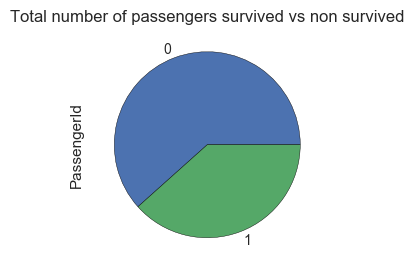

In [171]:
describe_data(titanic, 'Survived', 'PassengerId', 'Total number of passengers survived vs non survived', 'pie')

### Question 2: What is the percentage of male passengers vs. female passenger in this data set?

** Answer:**

** 64.8% (577 male passengers) vs. 35.2% (314 female passengers) in this data set **

(        Count  Percentage
 Sex                      
 female    314   35.241302
 male      577   64.758698,
 <matplotlib.axes._subplots.AxesSubplot at 0x11db66a0>)

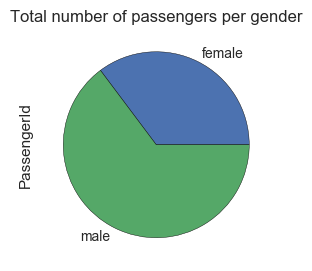

In [172]:
describe_data(titanic, 'Sex', 'PassengerId', 'Total number of passengers per gender', 'pie')

### Question 3: How are passengers distributed by class in this data set?

** Answer:**

**1st class** represents    24.2% (216 passengers) in blue on pie plot

**2nd class** represents    20.6% (184 passengers)in green on pie plot.

**3rd class** represents 55.1% (491 passengers) in red on pie plot.

Most of passengers in this data set were traveling in 3rd class.
     

(        Count  Percentage
 Pclass                   
 1         216   24.242424
 2         184   20.650954
 3         491   55.106622,
 <matplotlib.axes._subplots.AxesSubplot at 0x127dcb38>)

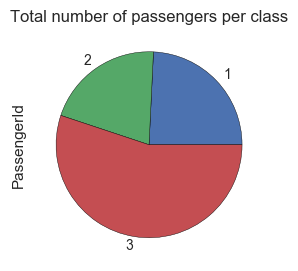

In [173]:
describe_data(titanic, 'Pclass', 'PassengerId', 'Total number of passengers per class', 'pie')

### Question 4: How are passengers distributed by age group?

**Answer:**

**On the histogram below we can see that the distribution is almost normal, slightly positively skewed, which means that there are more younger passengers.** 

**50% of passengers are below 30 years. Mean age is 29.6. The oldest passenger was 80 years old and the youngest was an infant less than 1 year old**

> Note that 177 missing age values have been filled.

count    891.000000
mean      29.610180
std       13.343754
min        0.420000
25%       22.000000
50%       30.000000
75%       36.000000
max       80.000000
Name: Age, dtype: float64


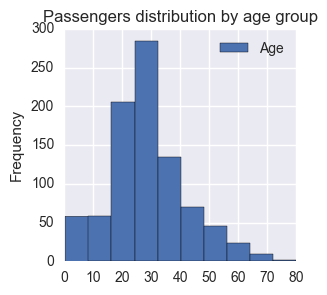

In [174]:
titanic['Age'].plot.hist(legend = True, title = 'Passengers distribution by age group', figsize = (3,3))
print titanic['Age'].describe()

### Question 5: How passengers of different classes differ in terms of age?

**Answer:**

Below we can see some statistics and histograms of age per passenger class. 

** We see that mean age is the highest for passengers of 1st class (37.5 years), then comes 2nd class with 29.9  years and last, 3rd class with 26 years. The median for 1st, 2nd and 3rd class respectively is 36, 30 and 26 years. The standard deviation is 13.9 and 13.5 years for 1st and 2nd class respectively and 11 years for 3rd class. That means that ages in 3rd class are less spread around the mean.**

** For the three classes the youngest passenger was under 1 year old and the oldest betweeen 70 and 80 yers old.**

** On histograms we can notice normal distribution for 1st class, normal, but narrow for 2nd class with more passengers under 8 years. The distribution for 3rd class is positively skewed.**

**In conclusion, we can say that in this data set 3rd class passengers were younger than passengers of 1st and 2nd class and 2nd class passengers were younger than 1st class passengers.**

In [175]:
titanic_1st = titanic.loc[titanic['Pclass'] == 1]
titanic_2nd = titanic.loc[titanic['Pclass'] == 2]
titanic_3rd = titanic.loc[titanic['Pclass'] == 3]

print titanic.groupby('Pclass').describe()['Age']

Pclass       
1       count    216.000000
        mean      37.541296
        std       13.909003
        min        0.920000
        25%       29.000000
        50%       36.000000
        75%       47.250000
        max       80.000000
2       count    184.000000
        mean      29.893098
        std       13.592413
        min        0.670000
        25%       23.000000
        50%       30.000000
        75%       36.000000
        max       70.000000
3       count    491.000000
        mean      26.015112
        std       11.349557
        min        0.420000
        25%       19.000000
        50%       26.000000
        75%       31.500000
        max       74.000000
Name: Age, dtype: float64


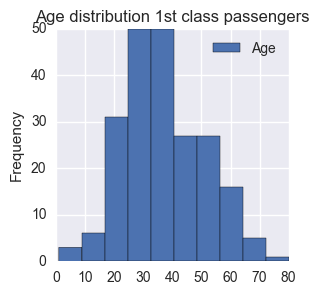

In [176]:
titanic_1st['Age'].plot.hist(legend = True, title = 'Age distribution 1st class passengers', figsize = (3, 3))


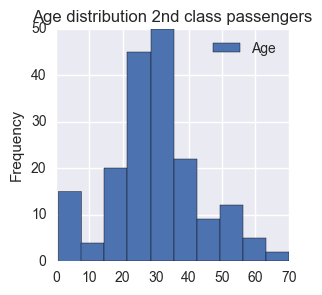

In [177]:
titanic_2nd['Age'].plot.hist(legend = True, title = 'Age distribution 2nd class passengers', figsize = (3, 3))


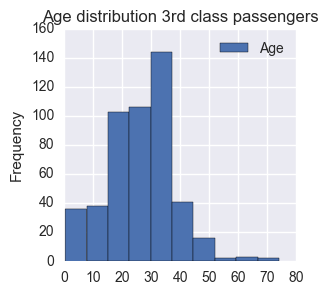

In [178]:
titanic_3rd['Age'].plot.hist(legend = True, title = 'Age distribution 3rd class passengers', figsize = (3, 3))

### Part 2: Questions about factors infuencing the survival

Now the most interesting part of this investigation is to try to understand which factors may have influenced the likelihood of survival. 
Of course, our results will be only tentative, as we don't use statistical hypothesis testing and will base our calculation on a sample, without population's parameters estimate.
But this is a heuristic solution that allows us to quickly make an educated guess about interdependancy of different variables. In this case the dependent variable is Survival (boolean), and independent variables that we will consider are: gender, passenger class, age and cabin location.

> Based on passengers recounts we know that women and children were given priority to get into boats. In this analysis we decided to consider two factors: gender and age separately as we don't know if gender influenced survival even for younger passengers. Later we will analyze survival rate per age group and gender and will see if there was a difference in survival rate between mae and female passengers for younger age groups.

### Question 6: Who was more likely to survive: male or female passengers?

** Answer:**

**Below we can see the percentage of survived passengers among men and the percentage of survived passengers among women. We can notice that the percentage of survived among women is 74% which seems significantly higher than percentage of survived among both genders (38.4%).** 

**As for men, their survival rate for this data set is only 18.8% which seems sgnificantly lower than percentage of survived among both genders.**

** Based on these observtions we could make a guess that women were more likely to survive than men. This is not based on a proper statistical testing.**

In [179]:
## The function below will be used several times to determine survival rate by category
## Groupby_column is category of passengers for which we calculate survival rate

def pct(data, groupby_column):
    pct_series = data.groupby(groupby_column).mean()['Survived']*100
    return pct_series 

In [180]:
pct_survivors_per_gender = pct(titanic, 'Sex')
print pct_survivors_per_gender

Sex
female    74.203822
male      18.890815
Name: Survived, dtype: float64


### Question 7: Did passenger class influence likelihood of survival?

** Below we can see the percentage of survived passengers per class. We can notice that survival rate decreases from 1st class to 3rd class. Survival rate among 1st class passengers is 62.9% which seems significantly higher than survival rate among all the passengers of this data set (general survival rate or 38.4%).** 

**Survival rate among 2nd class passengers is 47.3% which is higher than general survival rate.**

**Survival rate among 3rd class passengers is 24.2% which seems significantly lower than general survival rate.**

**Based on these observtions we could make a guess that 1st class passengers were more likely to survive than those from 2nd class and those from 2nd class  - more likely to survive than 3rd class passengers. This is not based on a proper statistical testing.**

In [181]:
pct_survivors_per_class = pct(titanic, 'Pclass')
print pct_survivors_per_class

Pclass
1    62.962963
2    47.282609
3    24.236253
Name: Survived, dtype: float64


But what if only one of these variables influences the survival rate? For example, only passenger class influences the survival and it just happens so that in this data set among 1st class passengers there were relatively more female passengers than among other classes.

We could control the variable class and see if in the same class female passengers are more likely to survive than male passengers.
We could also control the variable gender and see if among female only 1st class passengers are more likely to survive.

In [182]:
pct_survivors_per_class_and_gender = pct(titanic, ['Pclass', 'Sex'])
print 'Survival rate per class and gender'
print pct_survivors_per_class_and_gender

Survival rate per class and gender
Pclass  Sex   
1       female    96.808511
        male      36.885246
2       female    92.105263
        male      15.740741
3       female    50.000000
        male      13.544669
Name: Survived, dtype: float64


We notice that whithin the same class female survival rate is much higher than male survival rate and is also higher than the survival rate within this class. 

- 96% for women vs 36% for men whithin 1st class (1st class survival rate is 62.9%), 

- 92% for women vs 15 for men within 2nd class (second class survival rate is 47.3%)

- and finally, 50% for women vs 13.5% for men within 3rd class (3rd class survival rate is 24.2%).

It seems very likely that gender influences the survival likelihood.

Now, let's present the same results in different order sorted first by gender. We will see if among female passengers as well as among male passengers those from 1st class were more likely to survive.

In [183]:
pct_survivors_per_gender_and_class = pct(titanic, ['Sex', 'Pclass'])
print 'Survival rate per gender and class'
print pct_survivors_per_gender_and_class

Survival rate per gender and class
Sex     Pclass
female  1         96.808511
        2         92.105263
        3         50.000000
male    1         36.885246
        2         15.740741
        3         13.544669
Name: Survived, dtype: float64


- We notice that among female passengers' survival rate is much higher for 1st (96.8%) and 2nd class (92.1%) than for 3rd class (50%). Both 1st and 2nd class female survival rate is higher than general female survival rate (74%).

- Among male passengers 1st class survival rate is higher than 2nd class survival rate which is higher than 3rd class survival rate. Only 1st class survival rate is higher than general male survival rate (18.8%). 

It seems that passenger class influences the survival likelihood. We can also guess that passenger class influences the likelihood of survival less than gender (based on data for 1st and 2nd class female passengers). 

### Question 8: Is age one of factors that influenced survival rate? 

** Answer:**

From the table representing survival rate per age group and histogram below it is difficult to conclude if there is a clear relation between these two variables.

There is a descending tendancy for survival rate as age increases. This is particularly clear for Children under 13, their survival rate is much higher (58.6%) than other age groups. At the same time, we notice that young adults under 29 have higher survival rate (39.3%) than teen (37%) and adult under 60, which may be related to other factors, for example, number of female passengers among them or number of 1st class passengers.

In [184]:
pct_survivors_per_agegroup = pct(titanic, 'Age_group')
print 'Survival rate per age group'
print pct_survivors_per_agegroup

Survival rate per age group
Age_group
1)Child under 13          58.666667
2)Teen under 19           37.142857
3)Young adult under 29    39.357430
4)Adult under 60          35.454545
5)Elderly under 100       22.727273
Name: Survived, dtype: float64


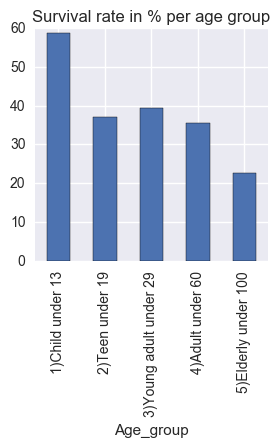

In [185]:
pct_survivors_per_agegroup.plot(title = 'Survival rate in % per age group', kind = 'bar', figsize = (3, 3))

Let's analyze data per age group and passenger class. For all three classes there is a descendent tendancy but not very clear. For 3rd class passengers we notice that elderly survival rate is higher than adults under 60 and young adult survival rate is higher than teen.
This is true for 2nd class.
As for 1st class passengers, children under 13 have lower survival rate than teen under 19.

                        1st cl_surv.rate  2nd cl_surv.rate  3rd cl_surv.rate
Age_group                                                                   
1)Child under 13               75.000000        100.000000         43.396226
2)Teen under 19                82.352941         47.058824         23.943662
3)Young adult under 29         71.428571         43.636364         30.817610
4)Adult under 60               62.328767         39.560440         14.285714
5)Elderly under 100            21.428571         33.333333         20.000000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000000136417B8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0000000013D49470>], dtype=object)

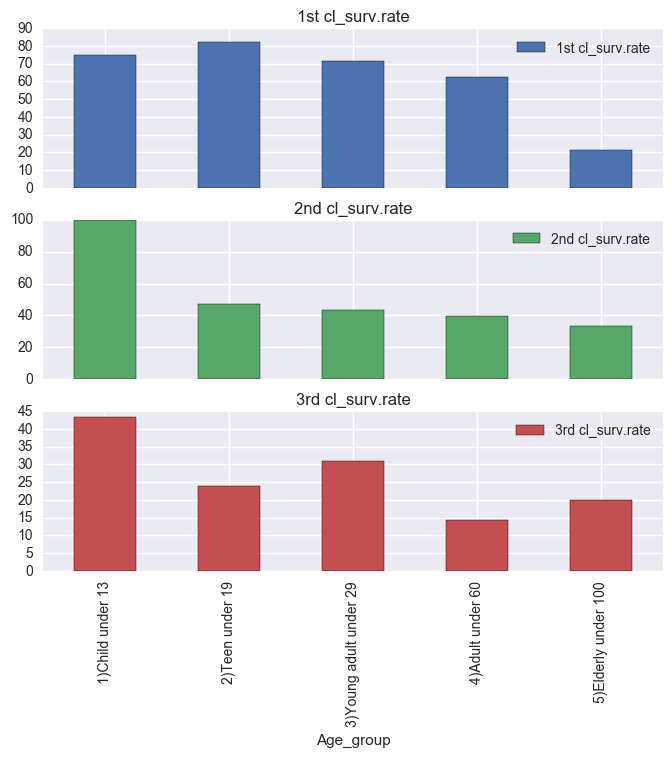

In [186]:
## Creating separate series for each passenger class with survival rate per age group.

pct_survivors_per_agegroup_1st = pct(titanic_1st, 'Age_group')
pct_survivors_per_agegroup_2nd = pct(titanic_2nd, 'Age_group')
pct_survivors_per_agegroup_3rd = pct(titanic_3rd, 'Age_group')

## Cresting a table with survival rate par age group and passenger class (in columns)

pct_survivors_per_agegroup = pd.concat([pct_survivors_per_agegroup_1st, pct_survivors_per_agegroup_2nd, \
                                    pct_survivors_per_agegroup_3rd], axis = 1)
pct_survivors_per_agegroup.columns = ['1st cl_surv.rate', '2nd cl_surv.rate', '3rd cl_surv.rate']

print pct_survivors_per_agegroup

pct_survivors_per_agegroup.plot(kind = 'bar', subplots = True, figsize = (8, 7))




> We can count number of passengers per age group for 1st class, for example. We see that ther are only 4 children under 13. There is probably not enough observations for this age group to make conclusions. We notice the same for elderly passengers in 3rd class.

In [187]:
print titanic_1st.groupby('Age_group').count()['Age']

Age_group
1)Child under 13            4
2)Teen under 19            17
3)Young adult under 29     35
4)Adult under 60          146
5)Elderly under 100        14
Name: Age, dtype: int64


In [188]:
print titanic_3rd.groupby('Age_group').count()['Age']

Age_group
1)Child under 13           53
2)Teen under 19            71
3)Young adult under 29    159
4)Adult under 60          203
5)Elderly under 100         5
Name: Age, dtype: int64


As we already observed that gender strongly influences survival rate, we could try to determmine if there is a relation between age group and survival rate among female passengers only and then male passengers only.
Here we have a surprise: among women survival rate increases as age increases. 

In [189]:
titanic_female = titanic.loc[titanic['Sex'] == 'female']
titanic_male = titanic.loc[titanic['Sex'] == 'male']

pct_survivors_per_agegroup_fem = pct(titanic_female, 'Age_group')
pct_survivors_per_agegroup_m = pct(titanic_male, 'Age_group')

pct_survivors_per_agegroup_fm = pd.concat([pct_survivors_per_agegroup_fem, pct_survivors_per_agegroup_m], axis = 1)
pct_survivors_per_agegroup_fm.columns = ['female surv.rate', 'male_surv.rate']

print pct_survivors_per_agegroup_fm

                        female surv.rate  male_surv.rate
Age_group                                               
1)Child under 13               61.764706       56.097561
2)Teen under 19                68.750000       10.526316
3)Young adult under 29         72.277228       16.891892
4)Adult under 60               80.468750       16.987179
5)Elderly under 100           100.000000       10.526316


Another analysis we could conduct is to calculate age statistics (mean, meadian, standard deviation etc) for survived passengers and for those who did not survive.
We observe that mean age values are close for both groups (30.3 for non survived and 28.4 for survived) and median age is 31.5 for non survived and 28 for survived. Standard deviation is close (12.7 for non survived and 14.1 for survived). Even quartiles are very close. 

In [190]:
titanic.groupby('Survived').describe()['Age']

Survived       
0         count    549.000000
          mean      30.356102
          std       12.773871
          min        1.000000
          25%       22.000000
          50%       31.500000
          75%       35.000000
          max       74.000000
1         count    342.000000
          mean      28.412778
          std       14.147908
          min        0.420000
          25%       20.250000
          50%       28.000000
          75%       36.750000
          max       80.000000
Name: Age, dtype: float64

** In conclusion, to answer the question about relation between age and survival rate, we have to admit that additional analysis is needed. We need more observatiions for certain age groups. There may be a relation but we cannot conclude it from this data set.**

## Question 9: Did cabin location influence survival rate?

There were recounts that "there was some variation in enforcement of the policy between the port and starboard sides of the boat deck. The crew on the port side strictly enforced the rule and would let no male passengers into the boats while the crew on the starboard side allowed male passengers a place when no more women could be found" [1]
It would be interesting to see of there is a variation in survival rate between passengers having their cabins on the port and starboard sides of the boat.
To avoid influence of gender factor we represent survival rate per side and per gender. Th table below shows number of male and female passengers per side and their survival rate. There is almost no difference between them.

In [191]:
print titanic.groupby(['Side', 'Sex']).count()['Survived']
print titanic.groupby(['Side', 'Sex']).mean()['Survived']

Side  Sex   
even  female    44
      male      66
odd   female    51
      male      39
Name: Survived, dtype: int64
Side  Sex   
even  female    0.909091
      male      0.424242
odd   female    0.960784
      male      0.435897
Name: Survived, dtype: float64


Let's calculate survival rate per deck and per gender. The tables below show number of passengers and the survival rate. Decks are designated by letters, from A to T. 

** We notice that survival rate is clearly lower for both male and female passengers having their cabin on deck C. We don't consider decks G and T as there are not enough observations and cabins on these lower decks were not 1st class (most of passengers with a cabin number in this data set were 1st class - 176 passengers, vs 16 of 2nd class and 12 of 3rd class).**

**For female passengers on other decks survival rate is 1 (or 100%). Female passengers in this data set having their cabins on deck C have survival rate of 0.8 (88%). For male on deck C survival rate is 34% which is lower than on other decks.**


In [192]:
print titanic.groupby(['Deck', 'Sex']).count()['Survived']
print titanic.groupby(['Deck', 'Sex']).mean()['Survived']

Deck  Sex   
A     female     1
      male      14
B     female    27
      male      20
C     female    27
      male      32
D     female    18
      male      15
E     female    15
      male      17
F     female     5
      male       8
G     female     4
T     male       1
Name: Survived, dtype: int64
Deck  Sex   
A     female    1.000000
      male      0.428571
B     female    1.000000
      male      0.400000
C     female    0.888889
      male      0.343750
D     female    1.000000
      male      0.466667
E     female    0.933333
      male      0.588235
F     female    1.000000
      male      0.375000
G     female    0.500000
T     male      0.000000
Name: Survived, dtype: float64


In [193]:
## Counting number of passenegers with cabin number in this data set per class.

titanic.loc[titanic['Cabin'].notnull()].groupby('Pclass').count()['PassengerId']

Pclass
1    176
2     16
3     12
Name: PassengerId, dtype: int64

** There are not enough records with cabin numbers to make conclusions. Nevertheless, based on these 204 records we could suppose that side of the boat did not influence the survival rate. Although the deck C may have had a particularity that could explain lower survival rate of passengers havig their cabins on this deck. We need additional data to make conclusions.**

# 5. Conclusion

** - Our analysis is based on a sample of 891 observtions. No estimation of population parameters has been done and no hypothesis testing conducted. The results are tentative and have their limits.**

** - One important limitation is sample that has not been randomly selected. We do not know why these particular passengers were on this list. So, the sample may be biased, ther may have been criteria of selection of passengers on this list that we do not know. That is why we can not estimate poopulation parameters based on this data set.
To estimate ppulation parameters we nee a randomly selected sample.**

** - We could suppose that gender is main factor that influenced the survival. We could conclude base on this data set that female passengers were more likely to survive. This is explained by boat commanders policy to let women get into boats first.**

** - Passeneger class seems to be the second factor influencing likelihood of survival. Nevertheless, there was only a small difference in survival rate between female passengers of 1st and 2nd classes based on this data set**

** - Age group may have been a factor of survival but only to a certin degree. Children under 13 had a higher survival rate throughout the three classes of this sample. There is a decreasing tendancy of survival rate with age increase but it is not verified for female passengers where the tendancy is reversed (higher survival rate as age increases). We may not have enough data to make conclusions on age factor.**

** - It seems that there is no relation between the side of the ship where cabins were located and survival rate. On the other hand, there may be a relation between the deck where cabins were located and survival rate. It is possible that there was a particularity for deck C that could explain lower survival rate for passenegers with cabins on this deck.**

References

1. Hall, Wayne. (1986). Social class and survival on SS Titanic. Retrieved from http://dx.doi.org/10.1016/0277-9536(86)90041-9

2. Titanic deckplans https://www.encyclopedia-titanica.org/titanic-deckplans/e-deck.html

3. Titanic survival data. Retrieved from http://www.statisticalconsultants.co.nz




          
